In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import config

plt.style.use('seaborn-v0_8')

/home/abian/Workspace/Anaconda/envs/CLHU/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, simplex_weight=1e-5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss() 
    volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')
    vol_reg_norm = volume_reg(torch.sigmoid(model.ebk.detach()))
    print(vol_reg_norm)
    


    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    similarity_weight = 1e-1

    scaler = torch.cuda.amp.GradScaler()

    for epoch in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + simplex_weight*(volume_reg(sigmoid(model.ebk))/vol_reg_norm) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

In [3]:
from scipy import io as sio

synthetic_data_path = "/home/abian/Data/Dataset/HSI/SyntheticData/"
data = sio.loadmat(synthetic_data_path + "Y.mat")
M = sio.loadmat(synthetic_data_path + "M.mat")['M_avg']
A = sio.loadmat(synthetic_data_path + "A.mat")['A'].T

X = data['Y'].T
X = X.reshape(data['nRow'].item(), data['nCol'].item(), -1, order='F')
A = A.reshape(data['nRow'].item(), data['nCol'].item(), -1, order='F')

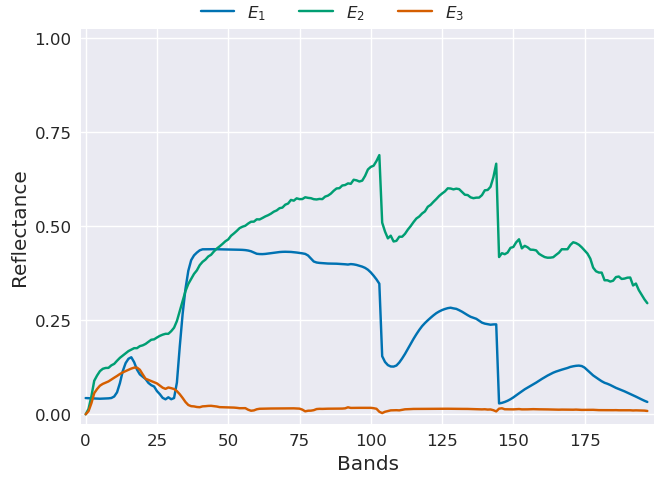

In [4]:
from utils import plot_endmembers
fig = plot_endmembers(M.T)
plt.show(fig)

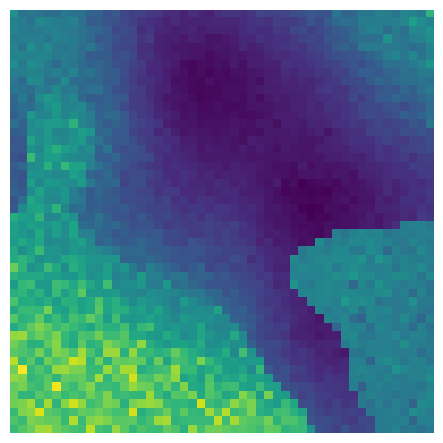

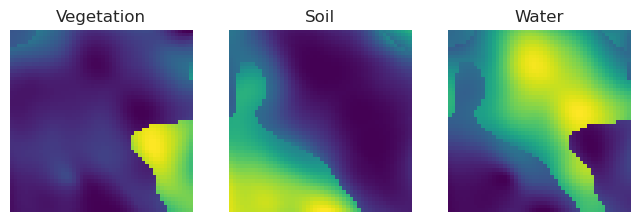

In [5]:
plt.imshow(X[:,:,100], cmap='viridis')
plt.axis('off')
plt.show()
labels = ['Vegetation', 'Soil', 'Water']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(A[:,:,i], cmap='viridis')
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [6]:
X.min()

-0.019276482964736615

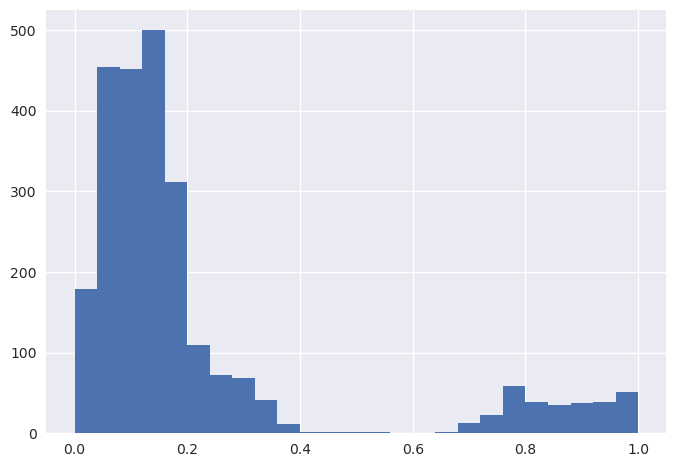

In [7]:
plt.hist(A[:,:,0].flatten(), bins=25)
plt.show()

In [8]:
_A = A.reshape(-1, A.shape[-1])
idx = np.argwhere(_A[:,2] > 0.5)[:,0]

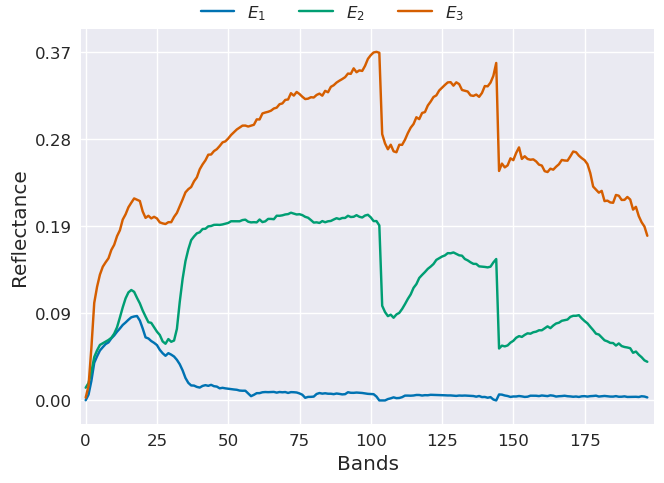

In [9]:
from HySpecLab.eea import VCA
_X = X.reshape(-1, X.shape[-1])
n_endmembers = 3
vca = VCA(n_endmembers, snr_input=30, random_state=25)
vca.fit(_X[idx])
endmembers = vca.endmembers()

plot_endmembers(endmembers, ticks_range=(endmembers.min(), endmembers.max()))
plt.show()

In [10]:
_X[idx].shape

(1282, 198)

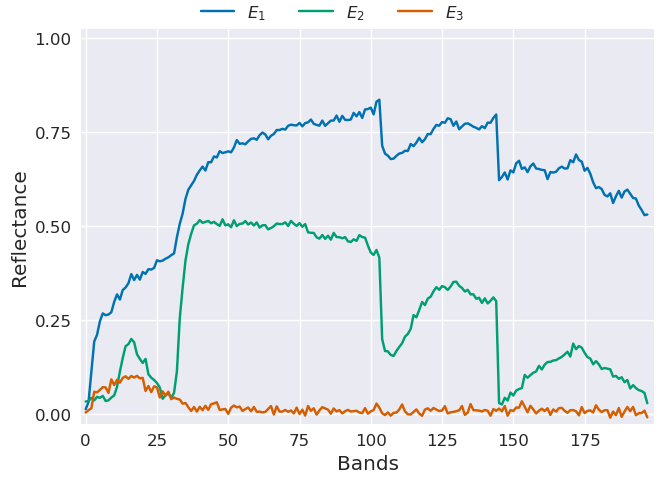

In [11]:
from utils import plot_endmembers
from pysptools import eea
# n_endmembers = dataset.n_endmembers
n_endmembers = 3

ee = eea.NFINDR()
endmember = ee.extract(X, n_endmembers)
endmember_init = torch.from_numpy(endmember).float()
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

# from utils import plot_endmembers
fig = plot_endmembers(endmember_init)
plt.show(fig)

In [12]:
X.shape

(50, 50, 198)

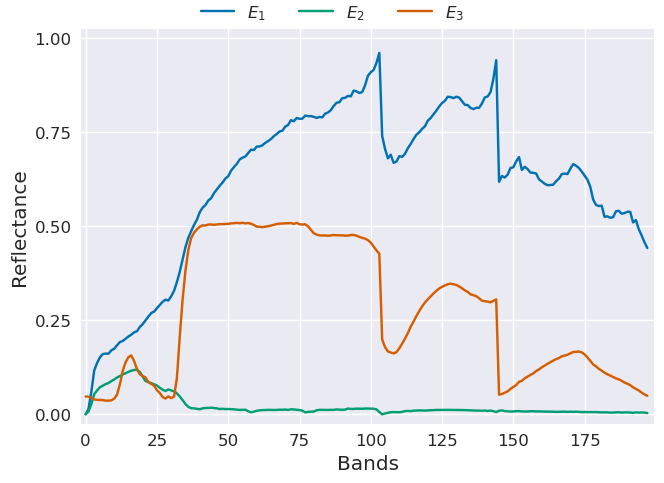

In [13]:
from HySpecLab.eea import VCA

vca = VCA(n_endmembers, snr_input=1, random_state=25)
vca.fit(X.reshape(-1, X.shape[-1]))
endmembers = vca.endmembers()

plot_endmembers(endmembers)
plt.show()

In [14]:
from torch.utils.data import Dataset
from dataset import HSIDataset

class SyntheticDataset(HSIDataset):
    def __init__(self, root_dir, transform=None):
        super(SyntheticDataset, self).__init__()
        data = sio.loadmat(os.path.join(root_dir, "Y.mat"))

        self.n_row, self.n_col , self.n_bands = data['nRow'].item(), data['nCol'].item(), data['nBand'].item()
        self.X = np.abs(data['Y'].T) # Because of the noise, there are negative values
        self.X = self.X.reshape(self.n_row, self.n_col, -1)
        self.X = self.preprocessing(self.X).reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)
        # self.X = self.X.reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)

        self.E = sio.loadmat(os.path.join(root_dir, "M.mat"))['M_avg'].T
        self.A = sio.loadmat(os.path.join(root_dir, "A.mat"))['A'].T

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.E = torch.tensor(self.E, dtype=torch.float32)
        self.A = torch.tensor(self.A, dtype=torch.float32)
        self.n_endmembers = self.E.shape[0]

        self.transform = transform

    def __len__(self):
        return self.n_row * self.n_col

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

    def endmembers(self):
        return self.E

    def abundance(self):
        return self.A.numpy().reshape(self.n_row, self.n_col, -1, order='F')

    def image(self):
        return self.X.numpy().reshape(self.n_row, self.n_col, -1)

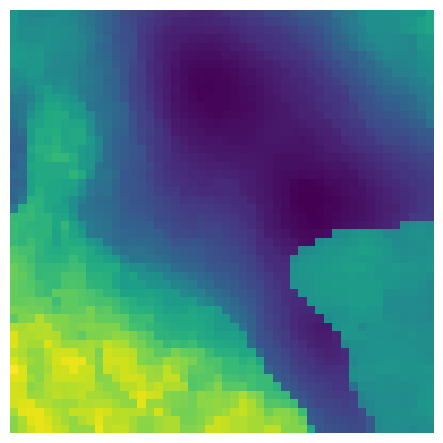

In [15]:
dataset = SyntheticDataset(synthetic_data_path)

plt.imshow(dataset.image()[:,:,100].T, cmap='viridis')
plt.axis('off')
plt.show()

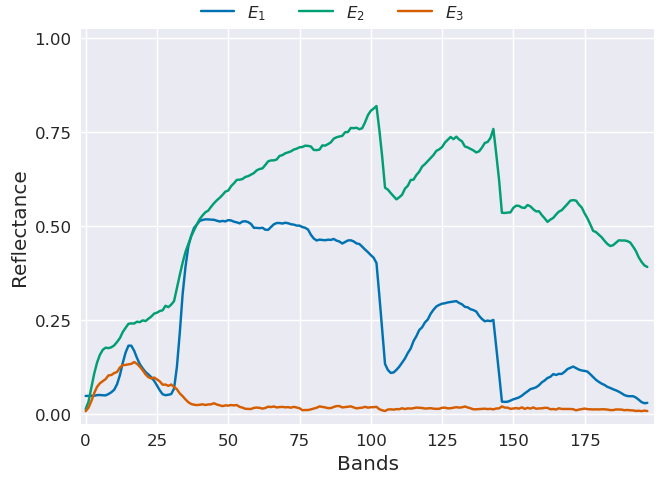

In [16]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = ee.extract(dataset.image(), n_endmembers)
endmember_init = torch.from_numpy(endmember).float()
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

# from utils import plot_endmembers
fig = plot_endmembers(endmember_init)
plt.show(fig)

In [17]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
# train(model, n_endmembers, dataset, n_batchs=32, n_epochs=100, lr=1e-3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, simplex_weight=1e-3)

tensor(64.4599, device='cuda:0')


100%|██████████| 50/50 [00:27<00:00,  1.83epoch/s, tls=0.0660]


In [18]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [19]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0235) tensor(0.6397) tensor(59.3298) tensor(0.2096)


In [20]:
volume_reg(endmember_init), similarity_reg(endmember_init)

(tensor(64.4599), tensor(0.1887))

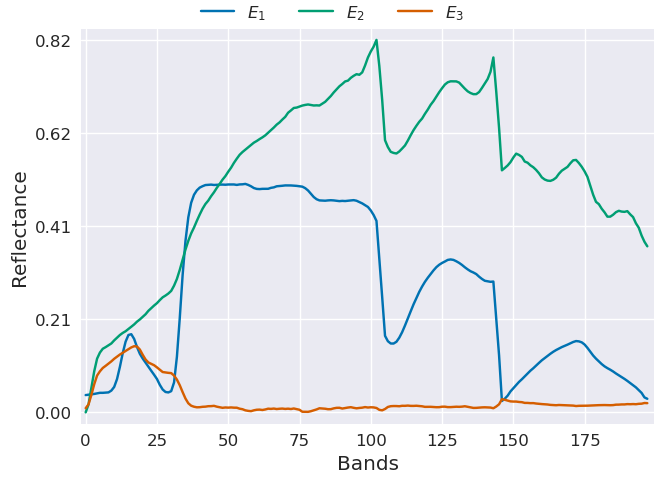

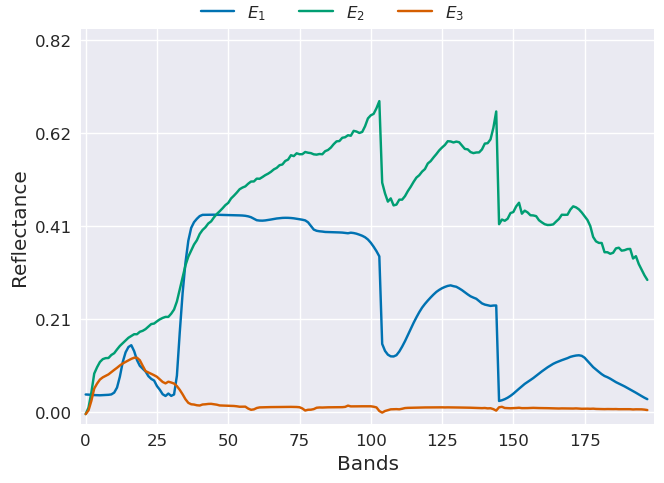

In [21]:
ebk = sigmoid(model.ebk).detach().cpu()

fig = plot_endmembers(ebk, ticks_range=(ebk.min(), ebk.max()))
plt.show(fig)

fig = plot_endmembers(dataset.endmembers(), ticks_range=(ebk.min(), ebk.max()))
plt.show(fig)

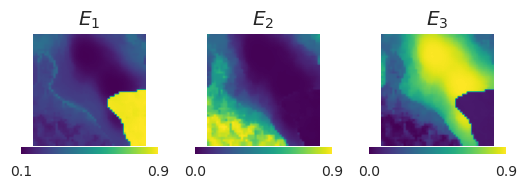

In [22]:
from torch.nn.functional import softmax
from utils import show_abundance

test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)
# test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test)
# fig.savefig('abundance.png', dpi=300, bbox_inches='tight')
plt.show(fig)

In [23]:
from HySpecLab.metrics import sad

sad_result = sad(ebk, torch.tensor(endmembers, dtype=torch.float))
sad_result

tensor([[0.4537, 1.1909, 0.0442],
        [0.0274, 1.1778, 0.4426],
        [1.1285, 0.1736, 1.2271]])

In [24]:
sad_result = sad(endmember_init, torch.tensor(endmembers, dtype=torch.float))
sad_result

tensor([[0.5185, 1.1872, 0.0953],
        [0.0476, 1.1574, 0.4112],
        [1.0829, 0.1226, 1.1259]])

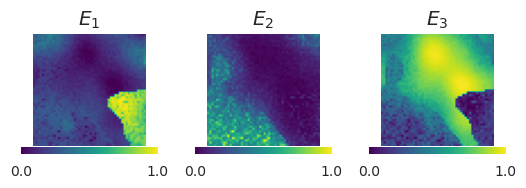

In [25]:
test = sio.loadmat(os.path.join(synthetic_data_path, 'A_est', 'FCLS.mat'))['A'].T
# from utils import plot_abundance
A = test.reshape(50,50,-1,order='C')
fig = show_abundance(A)
plt.show(fig)

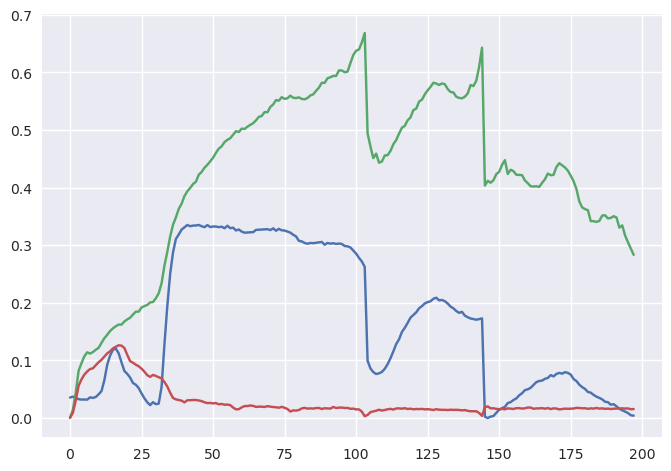

In [72]:
data = sio.loadmat(os.path.join(synthetic_data_path, 'M_est', 'Fractional.mat'))
M = data['M']
plt.plot(M[:,:,2000])
plt.show()

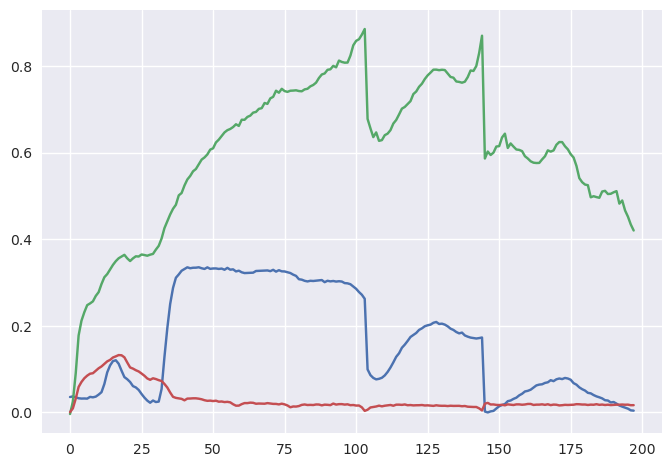

In [73]:
plt.plot(M[:,:,1000])
plt.show()